In [18]:

import numpy as np
import torch
from torch.fft import ifft2, fftshift
from matplotlib import pyplot as plt

In [19]:
fx1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), 128)
fy1D = torch.linspace(-np.pi/(3.2e-3), np.pi/(3.2e-3), 128)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D)
k2D = torch.sqrt(fx2D**2 + fy2D**2) * 128
theta2D = torch.arctan2(fy2D, fx2D)

In [20]:
def wavefront(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta + phi1) + C2 * torch.cos(2 * theta + phi2)
    # return lambda theta: theta * 0

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = fftshift(ifft2(tf)).abs()
    psf /= psf.sum(axis=(-2,-1))
    return psf

w = wavefront(2e-4, 5e-5, np.pi/3, 5e-5, -2*np.pi/3)
psf = PSF(theta2D, k2D, w, 0.8e-3)

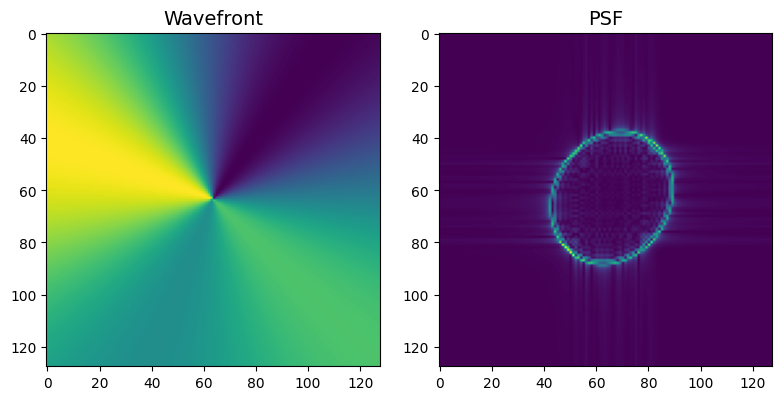

In [21]:
plt.figure(figsize=(8, 5))
plt.subplot(1,2,1)
plt.imshow(w(theta2D))
plt.title('Wavefront', fontsize=14)

plt.subplot(1,2,2)
plt.imshow(psf)
plt.title('PSF', fontsize=14)

plt.tight_layout()